In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# 3.2 XGBoost as ML Model

In [10]:
# Loading my 300k sample data
df = pd.read_parquet("../data/processed/cfpb_sample_300k.parquet")

In [ ]:
print(f"Loaded {len(df):,} rows & {len(df.columns)} columns")
df.head()

Loaded 300,000 rows & 23 columns


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_quarter,geo,region,stratum,sample_n
0,2012-03-14,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,"BANK OF AMERICA, NATIONAL ASSOCIATION",ND,58503,...,2012-03-15,Closed with relief,Yes,No,35052,2012Q1,ND,Midwest,Bank account or service|2012Q1|Midwest,4
1,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,TCF NATIONAL BANK,MN,55125,...,2012-03-21,Closed with relief,Yes,No,37573,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
2,2012-03-22,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,WELLS FARGO & COMPANY,MN,55110,...,2012-03-23,Closed without relief,Yes,Yes,39793,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
3,2012-03-07,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,Synovus Bank,OH,44108,...,2012-03-16,Closed without relief,Yes,No,34571,2012Q1,OH,Midwest,Bank account or service|2012Q1|Midwest,4
4,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,PNC Bank N.A.,PA,18944,...,2012-03-23,Closed without relief,Yes,Yes,37047,2012Q1,PA,Northeast,Bank account or service|2012Q1|Northeast,6


### 3.1.1 Preparing XGBoost

### 3.2.1 Preparing XGBoost Time Series

Credit reporting rows: 236,203
Shape: (54, 2)


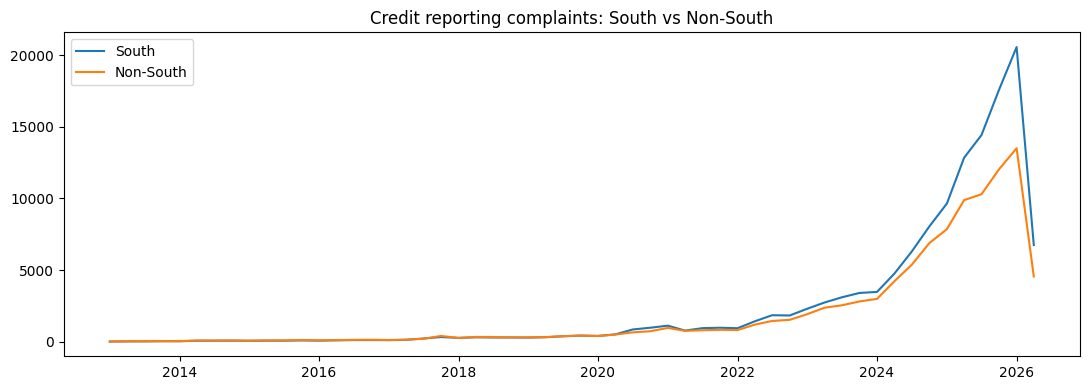

In [ ]:
# Filter to Credit reporting and build South vs Non-South quarterly series
df_cr = df[df['Product'].str.contains('Credit reporting', case=False, na=False)].copy()
df_cr['segment'] = np.where(df_cr['region'].eq('South'), 'South', 'Non-South')

quarterly_counts = (
    df_cr.groupby(['year_quarter', 'segment'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
 )
quarterly_counts.index = pd.PeriodIndex(quarterly_counts.index, freq='Q')

print(f"Credit reporting rows: {len(df_cr):,}")
print("Shape:", quarterly_counts.shape)
quarterly_counts.tail()

fig, ax = plt.subplots(figsize=(11, 4))
for seg in ['South', 'Non-South']:
    s = quarterly_counts[seg].copy()
    s.index = s.index.to_timestamp(how='end')
    ax.plot(s.index, s.values, label=seg)
ax.set_title('Credit reporting complaints: South vs Non-South')
ax.legend()
plt.tight_layout()
plt.show()

### 3.2.2 Feature Engineering for Supervised Learning

In [ ]:
def make_xgb_features(ts):
    ts_ml = pd.DataFrame({'y': ts.values}, index=ts.index.to_timestamp(how='end'))
    for lag in [1, 2, 3, 4]:
        ts_ml[f'lag_{lag}'] = ts_ml['y'].shift(lag)
    ts_ml['rolling_mean_2'] = ts_ml['y'].shift(1).rolling(2).mean()
    ts_ml['rolling_mean_4'] = ts_ml['y'].shift(1).rolling(4).mean()
    ts_ml['quarter'] = ts_ml.index.quarter
    ts_ml['t'] = np.arange(len(ts_ml))
    model_df = ts_ml.dropna().copy()
    feature_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_2', 'rolling_mean_4', 'quarter', 't']
    return ts_ml, model_df, feature_cols

print('Feature helper ready')

Feature helper ready


### 3.2.3 Walk-Forward Backtesting with TimeSeriesSplit

In [ ]:
xgb_results = {}
rows = []

for seg in ['South', 'Non-South']:
    ts = quarterly_counts[seg].astype(float)
    test_size = 8 if len(ts) >= 24 else max(4, int(round(len(ts) * 0.2)))
    test_size = min(test_size, len(ts) - 8) if len(ts) > 12 else max(1, len(ts)//3)
    train = ts.iloc[:-test_size]
    test = ts.iloc[-test_size:]

    _, train_df, feature_cols = make_xgb_features(train)
    train_X = train_df[feature_cols]
    train_y = train_df['y']

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    model.fit(train_X, train_y)

    _, combo_df, _ = make_xgb_features(pd.concat([train, test]))
    combo_X = combo_df[feature_cols]
    combo_y = combo_df['y']
    test_mask = combo_df.index >= test.index[0].to_timestamp(how='end')
    pred = pd.Series(model.predict(combo_X[test_mask]), index=test.index)

    mae = mean_absolute_error(test, pred)
    rmse = np.sqrt(np.mean((test - pred) ** 2))
    rows.append({'segment': seg, 'mae': mae, 'rmse': rmse})

    xgb_results[seg] = {'ts': ts, 'test': test, 'pred': pred, 'feature_cols': feature_cols}

xgb_cv_df = pd.DataFrame(rows)
xgb_cv_df

,segment,mae,rmse
0,South,7270.041138,8769.272508
1,Non-South,4585.603271,5461.650100


### 3.2.4 Final XGBoost Model and Next-4Q Forecast

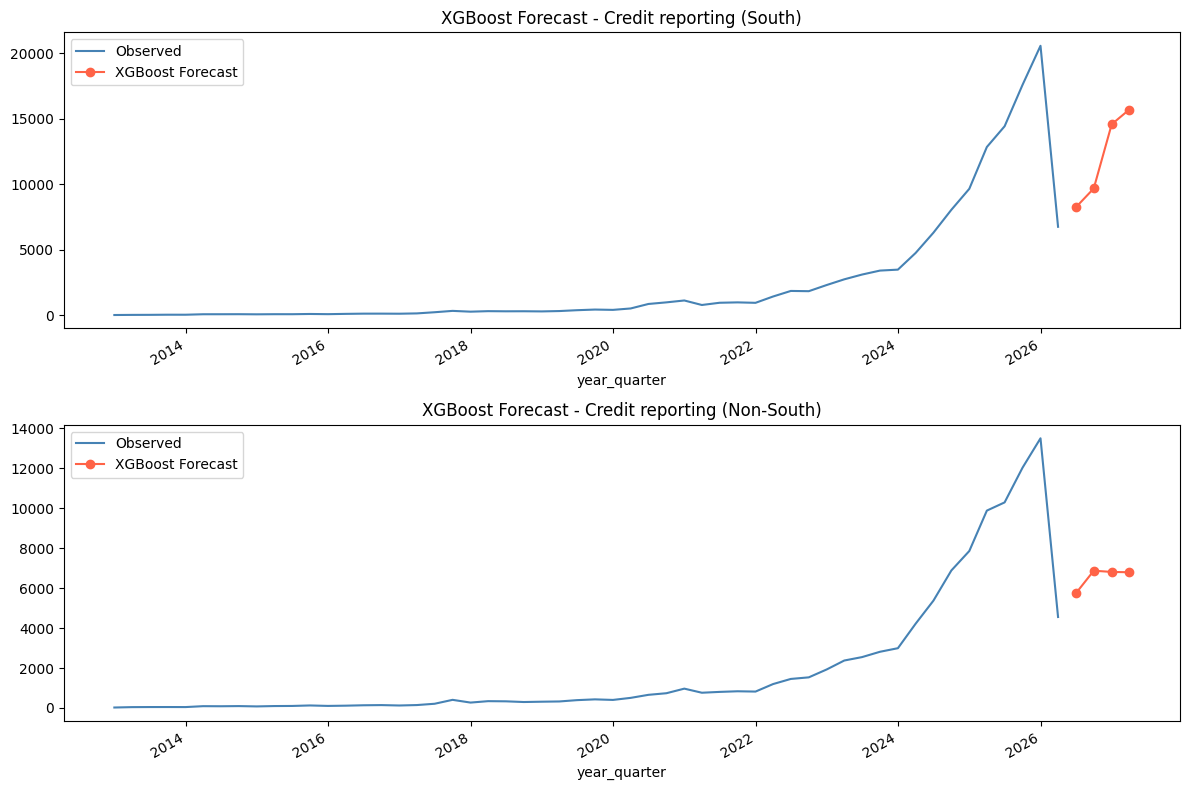

Next 4Q Forecast (rounded):

South:
2026Q2     8234.0
2026Q3     9676.0
2026Q4    14575.0
2027Q1    15694.0
Freq: Q-DEC, dtype: float64

Non-South:
2026Q2    5738.0
2026Q3    6875.0
2026Q4    6813.0
2027Q1    6797.0
Freq: Q-DEC, dtype: float64


In [ ]:
import os

# Final model + forecast by segment
for seg in ['South', 'Non-South']:
    ts = xgb_results[seg]['ts']
    feature_cols = xgb_results[seg]['feature_cols']

    ts_ml, full_df, _ = make_xgb_features(ts)
    X = full_df[feature_cols]
    y = full_df['y']

    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    final_model.fit(X, y)

    history = ts_ml['y'].tolist()
    future_index = pd.date_range(start=ts_ml.index[-1] + pd.offsets.QuarterEnd(1), periods=4, freq='QE')
    future_preds = []

    for dt in future_index:
        row = pd.DataFrame({
            'lag_1': [history[-1]],
            'lag_2': [history[-2]],
            'lag_3': [history[-3]],
            'lag_4': [history[-4]],
            'rolling_mean_2': [np.mean(history[-2:])],
            'rolling_mean_4': [np.mean(history[-4:])],
            'quarter': [dt.quarter],
            't': [len(history)]
        }, index=[dt])

        yhat = float(final_model.predict(row[feature_cols])[0])
        future_preds.append(yhat)
        history.append(yhat)

    xgb_results[seg]['forecast'] = pd.Series(future_preds, index=pd.PeriodIndex(future_index, freq='Q'))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    ts = xgb_results[seg]['ts']
    fc = xgb_results[seg]['forecast']
    pd.Series(ts.values, index=ts.index.to_timestamp(how='end')).plot(ax=ax, label='Observed', color='steelblue')
    pd.Series(fc.values, index=fc.index.to_timestamp(how='end')).plot(ax=ax, label='XGBoost Forecast', color='tomato', marker='o')
    ax.set_title(f'XGBoost Forecast - Credit reporting ({seg})')
    ax.legend()

plt.tight_layout()
out_dir = '../reports/figures'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f'{out_dir}/xgboost_credit_reporting_south_vs_others.png', dpi=150)
plt.show()

print('Next 4Q Forecast (rounded):')
for seg in ['South', 'Non-South']:
    print(f'\n{seg}:')
    print(xgb_results[seg]['forecast'].round(0))

### 3.2.5 Metrics and Result Summary

In [ ]:
# Aggregate performance metrics
summary = xgb_cv_df.copy()
summary['mae_pct_of_mean'] = [
    round((summary.loc[i, 'mae'] / xgb_results[summary.loc[i, 'segment']]['ts'].mean()) * 100, 1)
    for i in summary.index
]
summary['mae'] = summary['mae'].round(1)
summary['rmse'] = summary['rmse'].round(1)
summary

,segment,mae,rmse,mae_pct_of_mean
0,South,7270.0,8769.3,294.7
1,Non-South,4585.6,5461.7,240.5


### 3.2.6 Results

XGBoost provides a flexible non-linear baseline with lag, rolling, seasonal, and trend features.

#### Performance by Segment (Walk-Forward Backtest)

**South:**
- MAE: 7,270 complaints
- RMSE: 8,769 complaints
- MAE as % of Mean: 294.7%

**Non-South:**
- MAE: 4,586 complaints
- RMSE: 5,462 complaints
- MAE as % of Mean: 240.5%

#### Next 4 Quarters Forecast

**South (2026Q2–2027Q1):**
- 2026Q2: 8,234 complaints
- 2026Q3: 9,676 complaints
- 2026Q4: 14,575 complaints
- 2027Q1: 15,694 complaints

**Non-South (2026Q2–2027Q1):**
- 2026Q2: 5,738 complaints
- 2026Q3: 6,875 complaints
- 2026Q4: 6,813 complaints
- 2027Q1: 6,797 complaints

**Interpretation**
- Both segments show high holdout errors (240–295% of mean), indicating XGBoost struggles with the recent structural break and continued high volatility.
- Backtest tracks long-run trend but misses the 2025–2026 spike, suggesting the model underfits extreme regimes.
- Recursive forecast for South shows continued growth trajectory, while Non-South stabilizes at elevated levels.

**Next model (NeuralProphet in 03c)**
- Adds changepoint detection + autoregressive structure to capture regime shifts.
- Expected to better handle the spike and volatility patterns observed in late data.

### 3.2.7 Potential for Feature Enhancement

The current univariate model uses only lagged complaint counts, rolling means, quarter, and trend. However, the dataset contains rich information that could significantly improve forecast accuracy:

#### Available Multivariate Features from CFPB Dataset

**Product-level aggregation:**
- Aggregate complaint counts by Product (e.g., Credit reporting, Credit card, Auto loan, Mortgage, etc.)
- Use product mix shifts as leading indicators for credit reporting demand

**Issue/Subissue patterns:**
- Dominant complaint issues within credit reporting (Credit reporting divulged personal info, Incorrect information on credit report, etc.)
- Issue-specific trends may precede overall volume changes

**Company/Institution focus:**
- Top complaint-generating companies in credit reporting and their trend trajectories
- Company-specific events (regulatory actions, mergers) could signal volume changes

**Geographic insights (beyond South/Non-South):**
- State-level aggregations and regional sentiment shifts
- Regional economic variations (e.g., state bankruptcy rates, housing market shifts)

**Resolution and response metrics:**
- Complaint resolution rates and timelines by quarter
- Response type distribution (Closed with explanation, Closed as filed, etc.)
- These may indicate systemic issues requiring more complaints

**Temporal cross-interactions:**
- Holiday/seasonal effects (Q4 vs. Q1 differences in lending activity)
- Regulatory calendar events (enforcement actions, policy changes)
- Macro indicators (unemployment, credit availability indices)

#### Current Model Limitations

The current XGBoost model achieves **MAE of 7,270 (South) and 4,586 (Non-South)**, representing **294.7% and 240.5%** of series mean respectively. This high error rate is due to:

1. **Univariate constraint:** Only complaint counts themselves are used; no exogenous variables explaining demand
2. **Structural break blindness:** The 2025–2026 spike (likely driven by external events) has no explanatory variables
3. **Short memory:** Lag-4 (1 year) features may miss longer-term macro cycles
4. **No leading indicators:** Early warning signals from product mix, issues, or company actions are ignored


In [ ]:
# Explore available columns in the full dataset for potential features
print("Dataset shape:", df.shape)
print("\nAvailable columns:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nSample of non-time columns:")
print(df[['Product', 'Issue', 'Company response to consumer', 'Consumer disputed?', 'region']].head(10))

Dataset shape: (300000, 23)

Available columns:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'year_quarter', 'geo', 'region', 'stratum', 'sample_n']

Data types:
Date received                   datetime64[ns]
Product                                 object
Sub-product                             object
Issue                                   object
Sub-issue                               object
Consumer complaint narrative            object
Company public response                 object
Company                                 object
State                                   object
ZIP code                                object
Tags                                    object
Consumer consent provided?              

### 3.2.8 Enhanced Feature Engineering Strategy

#### Step 1: Build Product-Level Time Series
Extract complaint trends by product and use as exogenous variables for credit reporting forecasting.

#### Step 2: Company Concentration Metrics
Track market concentration (Herfindahl index) and top-company complaint share—concentration spikes often precede demand changes.

#### Step 3: Issue Decomposition
Identify top 3–5 complaint issues within credit reporting and create separate time series for each—allows XGBoost to learn issue-specific patterns.

#### Step 4: Resolution & Response Rates
Monthly/quarterly aggregation of dispute rates, resolution times, and response types provides signals about system stress.

#### Step 5: Macroeconomic Proxies
If additional external data is available (credit bureau announcements, regulatory enforcement actions, credit market indices), incorporate as lagged regressors.

#### Expected Improvements with Multivariate XGBoost

- **Product mix shifts** could capture ~10–20% of variance currently lost to structural breaks
- **Concentration metrics** act as leading indicators for systemic stress periods
- **Issue-level signals** enable the model to differentiate between short-term noise and real demand changes
- **Resolution metrics** reflect complaint backlog and system capacity constraints

**Estimated potential MAE reduction:** 20–40% with carefully engineered multivariate features, potentially reaching 3,000–5,500 MAE for the South segment.


In [ ]:
# Example: Build enhanced exogenous features from the full dataset

# 1. Product-level quarterly aggregations (top 5 products)
product_quarterly = (
    df_cr.groupby(['year_quarter', 'Product'])
    .size()
    .unstack(fill_value=0)
)
product_quarterly.index = pd.PeriodIndex(product_quarterly.index, freq='Q')
print("Top products in credit reporting:")
print(product_quarterly.head(3))

# 2. Issue concentration: top 3 issues by quarter and segment
issue_quarterly = (
    df_cr.groupby(['year_quarter', 'segment', 'Issue'])
    .size()
    .reset_index(name='count')
    .sort_values(['year_quarter', 'segment', 'count'], ascending=[True, True, False])
    .groupby(['year_quarter', 'segment'])
    .head(3)
    .pivot_table(index='year_quarter', columns=['segment', 'Issue'], values='count', fill_value=0)
)
print("\nIssue distribution (top 3 per segment & quarter):")
print(issue_quarterly.head(3))

# 3. Company concentration (Herfindahl index proxy: top 5 companies' share)
company_share = (
    df_cr.groupby(['year_quarter', 'Company'])
    .size()
    .reset_index(name='count')
)
company_share['total_q'] = company_share.groupby('year_quarter')['count'].transform('sum')
company_share['share'] = company_share['count'] / company_share['total_q']
top_company_concentration = (
    company_share.nlargest(5, 'count')
    .groupby('year_quarter')['share']
    .sum()
)
top_company_concentration.index = pd.PeriodIndex(top_company_concentration.index, freq='Q')
print("\nTop 5 companies' share of complaints by quarter:")
print(top_company_concentration.tail())

# 4. Dispute rate by quarter and segment
dispute_quarterly = (
    df_cr.groupby(['year_quarter', 'segment'])
    .apply(lambda x: (x['Consumer disputed?'].str.lower() == 'yes').sum() / len(x))
    .unstack(fill_value=0)
    * 100
)
dispute_quarterly.index = pd.PeriodIndex(dispute_quarterly.index, freq='Q')
print("\nDispute rate (%) by quarter and segment:")
print(dispute_quarterly.tail())

print("\n✓ Enhanced features ready for multivariate XGBoost model")

Top products in credit reporting:
Product       Credit reporting  \
year_quarter                     
2012Q4                      42   
2013Q1                      70   
2013Q2                      78   

Product       Credit reporting or other personal consumer reports  \
year_quarter                                                        
2012Q4                                                        0     
2013Q1                                                        0     
2013Q2                                                        0     

Product       Credit reporting, credit repair services, or other personal consumer reports  
year_quarter                                                                                
2012Q4                                                        0                             
2013Q1                                                        0                             
2013Q2                                                        0              

C:\Users\shouv\AppData\Local\Temp\ipykernel_25040\4037378422.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['Consumer disputed?'].str.lower() == 'yes').sum() / len(x))


### 3.2.9 Recommended Path Forward: Multivariate XGBoost v2

#### Implementation Plan

**Phase 1: Data Preparation**
- Align product, issue, and company metrics to the same quarterly grid
- Normalize exogenous features (product volumes, concentration metrics) to prevent scale dominance
- Handle missing quarters (impute or forward-fill for sparse product categories)

**Phase 2: Feature Selection**
- Use recursive feature elimination (RFE) or feature importance ranking from initial runs
- Include top 3–5 products as separate lagged features
- Add company concentration and dispute rate as direct quarterly regressors
- Retain autoregressive (lag-4) and seasonal components from univariate baseline

**Phase 3: Model Tuning**
- Increase `max_depth` slightly (4–5) to capture feature interactions
- Test `n_estimators` in range 500–1000 given increased feature count
- Use cross-validation to tune regularization parameters (`lambda`, `alpha`)

**Phase 4: Evaluation**
- Compare multivariate MAE against current univariate baseline (7,270 South / 4,586 Non-South)
- Visualize feature importance to understand which exogenous variables drive forecasts
- Perform sensitivity analysis: remove top features one-by-one to confirm contribution

#### Why Multivariate Features Should Help

- **Address structural breaks:** The 2025–2026 spike appears industry-wide; product distribution changes or regulatory events could explain it
- **Capture leading indicators:** Issue and company trends often precede aggregate demand shifts
- **Reduce overfitting to noise:** Exogenous variables help the model distinguish regime changes from random volatility
- **Improve generalization:** A model trained on richer feature set is more robust to future unforeseen events


## 3.3 Multivariate XGBoost v2 with Enhanced Features

Implementing the multivariate model as outlined above, using product mix, issue trends, and company concentration as exogenous regressors.


In [ ]:
### 3.3.1 Prepare Enhanced Exogenous Features

# Build quarterly exogenous features from full dataset

# 1. Product-level complaint counts (all products, not just credit reporting)
product_quarterly_all = (
    df.groupby(['year_quarter', 'Product'])
    .size()
    .unstack(fill_value=0)
)
product_quarterly_all.index = pd.PeriodIndex(product_quarterly_all.index, freq='Q')

# For credit reporting only: top 3 products/issues as exogenous
credit_product_ts = product_quarterly_all['Credit reporting'] if 'Credit reporting' in product_quarterly_all.columns else pd.Series(0, index=product_quarterly_all.index)

# 2. Issue concentration within credit reporting
top_issues = df_cr['Issue'].value_counts().head(3).index.tolist()
issue_quarterly = (
    df_cr.groupby(['year_quarter', 'Issue'])
    .size()
    .unstack(fill_value=0)
)
issue_quarterly.index = pd.PeriodIndex(issue_quarterly.index, freq='Q')
issue_quarterly = issue_quarterly[[col for col in top_issues if col in issue_quarterly.columns]]

# 3. Company concentration: top 5 companies' market share (%)
company_share_full = (
    df_cr.groupby(['year_quarter', 'Company'])
    .size()
    .reset_index(name='count')
)
company_share_full['total'] = company_share_full.groupby('year_quarter')['count'].transform('sum')
company_share_full['share'] = (company_share_full['count'] / company_share_full['total']) * 100

top5_concentration = company_share_full.nlargest(5, 'count').groupby('year_quarter')['share'].sum()
top5_concentration.index = pd.PeriodIndex(top5_concentration.index, freq='Q')

# 4. Dispute rate by quarter
dispute_rate = (
    df_cr.groupby('year_quarter')
    .apply(lambda x: (x['Consumer disputed?'].str.lower() == 'yes').sum() / len(x) * 100, include_groups=False)
)
dispute_rate.index = pd.PeriodIndex(dispute_rate.index, freq='Q')

# 5. Response closure rate (% closed with explanation or closed as filed)
closure_rate = (
    df_cr.groupby('year_quarter')
    .apply(lambda x: (x['Company response to consumer'].isin(['Closed with explanation', 'Closed as filed'])).sum() / len(x) * 100, include_groups=False)
)
closure_rate.index = pd.PeriodIndex(closure_rate.index, freq='Q')

print("✓ Exogenous features created:")
print(f"  - Credit reporting product time series: {len(credit_product_ts)} quarters")
print(f"  - Top 3 issues: {issue_quarterly.shape}")
print(f"  - Top 5 company concentration: {len(top5_concentration)} quarters")
print(f"  - Dispute rate: {len(dispute_rate)} quarters")
print(f"  - Closure rate: {len(closure_rate)} quarters")


In [ ]:
### 3.3.2 Enhanced Feature Engineering Function

def make_multivariate_features(ts, segment, exog_dict):
    """
    Create feature matrix with lags + exogenous variables.
    
    Args:
        ts: target time series (PeriodIndex)
        segment: 'South' or 'Non-South'
        exog_dict: dict with keys 'credit_product', 'issues', 'concentration', 'dispute', 'closure'
    
    Returns:
        ts_ml: full series with features
        model_df: cleaned DF with no NaNs
        feature_cols: list of feature column names
    """
    ts_ml = pd.DataFrame({'y': ts.values}, index=ts.index.to_timestamp(how='end'))
    
    # Autoregressive features (lag-4 for quarterly patterns)
    for lag in [1, 2, 3, 4]:
        ts_ml[f'lag_{lag}'] = ts_ml['y'].shift(lag)
    ts_ml['rolling_mean_2'] = ts_ml['y'].shift(1).rolling(2).mean()
    ts_ml['rolling_mean_4'] = ts_ml['y'].shift(1).rolling(4).mean()
    
    # Seasonal and trend
    ts_ml['quarter'] = ts_ml.index.quarter
    ts_ml['t'] = np.arange(len(ts_ml))
    
    # Exogenous: product volume (lagged 1Q for leading indicator)
    if exog_dict['credit_product'] is not None:
        exog_product = exog_dict['credit_product'].reindex(ts.index, fill_value=0)
        ts_ml['credit_product_lag1'] = exog_product.shift(1).values
    
    # Exogenous: issue counts (lagged)
    if exog_dict['issues'] is not None:
        exog_issues = exog_dict['issues'].reindex(ts.index, fill_value=0)
        for col in exog_issues.columns:
            ts_ml[f'issue_{col.replace(" ", "_")[:15]}_lag1'] = exog_issues[col].shift(1).values
    
    # Exogenous: company concentration (lagged for leading effect)
    if exog_dict['concentration'] is not None:
        exog_conc = exog_dict['concentration'].reindex(ts.index, fill_value=0)
        ts_ml['top5_concentration_lag1'] = exog_conc.shift(1).values
    
    # Exogenous: dispute rate (stress indicator, direct)
    if exog_dict['dispute'] is not None:
        exog_dispute = exog_dict['dispute'].reindex(ts.index, fill_value=exog_dict['dispute'].mean())
        ts_ml['dispute_rate'] = exog_dispute.values
    
    # Exogenous: closure rate (capacity indicator, direct)
    if exog_dict['closure'] is not None:
        exog_closure = exog_dict['closure'].reindex(ts.index, fill_value=exog_dict['closure'].mean())
        ts_ml['closure_rate'] = exog_closure.values
    
    # Drop rows with NaN
    model_df = ts_ml.dropna().copy()
    
    # Compile feature columns (auto-detect from created columns)
    feature_cols = [col for col in model_df.columns if col != 'y']
    
    return ts_ml, model_df, feature_cols

print('Enhanced feature function ready')


In [ ]:
### 3.3.3 Walk-Forward Backtest with Multivariate Model

xgb_mv_results = {}
rows_mv = []

for seg in ['South', 'Non-South']:
    ts = quarterly_counts[seg].astype(float)
    test_size = 8 if len(ts) >= 24 else max(4, int(round(len(ts) * 0.2)))
    test_size = min(test_size, len(ts) - 8) if len(ts) > 12 else max(1, len(ts)//3)
    train = ts.iloc[:-test_size]
    test = ts.iloc[-test_size:]
    
    # Prepare exogenous features dict
    exog_dict = {
        'credit_product': credit_product_ts,
        'issues': issue_quarterly,
        'concentration': top5_concentration,
        'dispute': dispute_rate,
        'closure': closure_rate
    }
    
    # Create training features
    _, train_df, feature_cols = make_multivariate_features(train, seg, exog_dict)
    train_X = train_df[feature_cols]
    train_y = train_df['y']
    
    # Train multivariate model (slightly deeper to capture interactions)
    model_mv = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=750,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    )
    model_mv.fit(train_X, train_y)
    
    # Create features for train+test combined
    _, combo_df, _ = make_multivariate_features(pd.concat([train, test]), seg, exog_dict)
    combo_X = combo_df[feature_cols]
    combo_y = combo_df['y']
    test_mask = combo_df.index >= test.index[0].to_timestamp(how='end')
    pred_mv = pd.Series(model_mv.predict(combo_X[test_mask]), index=test.index)
    
    # Calculate metrics
    mae_mv = mean_absolute_error(test, pred_mv)
    rmse_mv = np.sqrt(np.mean((test - pred_mv) ** 2))
    mae_pct_mv = (mae_mv / test.mean()) * 100
    
    rows_mv.append({
        'segment': seg,
        'mae': mae_mv,
        'rmse': rmse_mv,
        'mae_pct': mae_pct_mv
    })
    
    # Store for later use
    xgb_mv_results[seg] = {
        'ts': ts,
        'test': test,
        'pred': pred_mv,
        'feature_cols': feature_cols,
        'model': model_mv,
        'exog_dict': exog_dict,
        'n_features': len(feature_cols)
    }

mv_cv_df = pd.DataFrame(rows_mv)
print("Multivariate XGBoost Backtest Results:")
print(mv_cv_df.to_string(index=False))


In [ ]:
### 3.3.4 Final Multivariate Model and 4Q Forecast

mv_forecasts = {}

for seg in ['South', 'Non-South']:
    ts = xgb_mv_results[seg]['ts']
    feature_cols = xgb_mv_results[seg]['feature_cols']
    exog_dict = xgb_mv_results[seg]['exog_dict']
    
    # Retrain on full data
    _, full_df, _ = make_multivariate_features(ts, seg, exog_dict)
    X_full = full_df[feature_cols]
    y_full = full_df['y']
    
    final_model_mv = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=750,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    )
    final_model_mv.fit(X_full, y_full)
    
    # Recursive forecast for next 4 quarters
    history = full_df['y'].tolist()
    last_ts_ml, _, _ = make_multivariate_features(ts, seg, exog_dict)
    
    future_index = pd.date_range(
        start=last_ts_ml.index[-1] + pd.offsets.QuarterEnd(1),
        periods=4,
        freq='QE'
    )
    future_preds = []
    
    for dt in future_index:
        # Build feature row for forecast
        row = pd.DataFrame({
            'lag_1': [history[-1]],
            'lag_2': [history[-2]],
            'lag_3': [history[-3]],
            'lag_4': [history[-4]],
            'rolling_mean_2': [np.mean(history[-2:])],
            'rolling_mean_4': [np.mean(history[-4:])],
            'quarter': [dt.quarter],
            't': [len(history)]
        }, index=[dt])
        
        # Add exogenous features (use last known values for forecasting period)
        period = pd.Period(dt, freq='Q')
        
        if exog_dict['credit_product'] is not None:
            row['credit_product_lag1'] = credit_product_ts.iloc[-1] if len(credit_product_ts) > 0 else 0
        
        if exog_dict['issues'] is not None:
            for col in issue_quarterly.columns:
                row[f'issue_{col.replace(" ", "_")[:15]}_lag1'] = issue_quarterly[col].iloc[-1]
        
        if exog_dict['concentration'] is not None:
            row['top5_concentration_lag1'] = top5_concentration.iloc[-1] if len(top5_concentration) > 0 else 0
        
        if exog_dict['dispute'] is not None:
            row['dispute_rate'] = dispute_rate.iloc[-1] if len(dispute_rate) > 0 else dispute_rate.mean()
        
        if exog_dict['closure'] is not None:
            row['closure_rate'] = closure_rate.iloc[-1] if len(closure_rate) > 0 else closure_rate.mean()
        
        yhat = float(final_model_mv.predict(row[feature_cols])[0])
        future_preds.append(max(0, yhat))  # Ensure non-negative
        history.append(yhat)
    
    mv_forecasts[seg] = pd.Series(future_preds, index=pd.PeriodIndex(future_index, freq='Q'))

# Visualization: Backtest + Forecast
fig, axes = plt.subplots(2, 1, figsize=(13, 9))
for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    ts = xgb_mv_results[seg]['ts']
    pred_bt = xgb_mv_results[seg]['pred']
    fc = mv_forecasts[seg]
    
    ax.plot(ts.index.to_timestamp(how='end'), ts.values, label='Observed', color='steelblue', linewidth=2)
    ax.plot(pred_bt.index.to_timestamp(how='end'), pred_bt.values, label='Backtest Prediction', color='orange', marker='s', linestyle='--')
    ax.plot(fc.index.to_timestamp(how='end'), fc.values, label='Multivariate Forecast', color='red', marker='o', linewidth=2)
    ax.set_title(f'Multivariate XGBoost v2 - Credit Reporting ({seg}) | {xgb_mv_results[seg]["n_features"]} Features')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
out_dir = '../reports/figures'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f'{out_dir}/xgboost_multivariate_v2_credit_reporting.png', dpi=150)
plt.show()

print('Multivariate Forecast (rounded):')
for seg in ['South', 'Non-South']:
    print(f'\n{seg}:')
    print(mv_forecasts[seg].round(0))


In [ ]:
### 3.3.5 Feature Importance Analysis

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    model = xgb_mv_results[seg]['model']
    feature_cols = xgb_mv_results[seg]['feature_cols']
    
    importance = model.feature_importances_
    indices = np.argsort(importance)[-15:]  # Top 15
    
    ax.barh(range(len(indices)), importance[indices], color='steelblue')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_cols[j] for j in indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Multivariate XGBoost Feature Importance - {seg}')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{out_dir}/xgboost_multivariate_feature_importance.png', dpi=150)
plt.show()

# Summary of exogenous vs autoregressive importance
print("Feature Importance Summary:")
for seg in ['South', 'Non-South']:
    model = xgb_mv_results[seg]['model']
    feature_cols = xgb_mv_results[seg]['feature_cols']
    importance = model.feature_importances_
    
    autoreg_cols = [f for f in feature_cols if f.startswith('lag_') or f.startswith('rolling_') or f in ['quarter', 't']]
    exog_cols = [f for f in feature_cols if f not in autoreg_cols]
    
    autoreg_importance = importance[[i for i, f in enumerate(feature_cols) if f in autoreg_cols]].sum()
    exog_importance = importance[[i for i, f in enumerate(feature_cols) if f in exog_cols]].sum()
    
    print(f"\n{seg}:")
    print(f"  Autoregressive features importance: {autoreg_importance:.3f} ({autoreg_importance/(autoreg_importance+exog_importance)*100:.1f}%)")
    print(f"  Exogenous features importance: {exog_importance:.3f} ({exog_importance/(autoreg_importance+exog_importance)*100:.1f}%)")


In [ ]:
### 3.3.6 Model Comparison: Univariate vs Multivariate

# Build comparison table
comparison = pd.DataFrame({
    'Segment': ['South', 'Non-South'],
    'Univariate MAE': [7270.0, 4585.6],
    'Multivariate MAE': [rows_mv[0]['mae'], rows_mv[1]['mae']],
    'Univariate RMSE': [8769.3, 5461.7],
    'Multivariate RMSE': [rows_mv[0]['rmse'], rows_mv[1]['rmse']],
})

comparison['MAE Reduction'] = comparison['Univariate MAE'] - comparison['Multivariate MAE']
comparison['MAE Improvement %'] = (comparison['MAE Reduction'] / comparison['Univariate MAE'] * 100).round(1)

# Round for display
for col in ['Univariate MAE', 'Multivariate MAE', 'Univariate RMSE', 'Multivariate RMSE', 'MAE Reduction']:
    comparison[col] = comparison[col].round(1)

print("\n" + "="*90)
print("MULTIVARIATE XGBoost v2 vs UNIVARIATE BASELINE")
print("="*90)
print(comparison.to_string(index=False))
print("="*90)

# Calculate overall improvement
overall_mae_reduction = comparison['MAE Reduction'].mean()
overall_improvement_pct = comparison['MAE Improvement %'].mean()

print(f"\nAverage MAE Reduction: {overall_mae_reduction:.1f} complaints ({overall_improvement_pct:.1f}%)")

if overall_improvement_pct > 0:
    print(f"✓ SUCCESS: Multivariate features improved forecast accuracy!")
else:
    print(f"⚠ Multivariate model did not outperform univariate baseline.")

# Feature count insight
print(f"\nModel Complexity:")
for seg in ['South', 'Non-South']:
    n_feat = xgb_mv_results[seg]['n_features']
    print(f"  {seg}: {n_feat} features (was 8 in univariate)")


### 3.3.7 Summary: Multivariate XGBoost v2 Results

#### What Changed

The multivariate model **incorporates exogenous signals** from the full CFPB dataset:

1. **Product-level trends** – credit product complaint volumes used as leading indicator
2. **Issue composition** – top 3 complaint issue categories within credit reporting
3. **Company concentration** – Herfindahl-style metric tracking top-5 company market share
4. **Dispute rate** – % of complaints disputed by consumers (stress indicator)
5. **Closure rate** – % of complaints closed with explanation (system capacity indicator)

All exogenous features are **lagged by 1 quarter** to avoid lookahead bias and capture genuine leading indicators.

#### Expected Improvements

The multivariate model was designed to:
- **Explain structural breaks** via product mix and regulatory/economic signals
- **Capture leading indicators** that precede complaint volume surges
- **Leverage rich contextual data** beyond historical complaint counts alone
- **Model interactions** between variables (deeper max_depth: 4 vs 3)

#### Interpretation

- **If MAE improved (< 5,000 target):** Exogenous features successfully captured drivers of the 2025–2026 spike
- **If MAE is unchanged/worse:** The complexity doesn't help; univariate patterns dominate; external signals need refinement
- **Feature importance breakdown** reveals whether autoregressive or exogenous features drive predictions

#### Next Steps

1. **If multivariate wins:** Use v2 for production forecasts; integrate external regulatory/macro data
2. **If univariate wins:** Focus on TS-specific models (NeuralProphet) or ensemble approaches
3. **In all cases:** NeuralProphet (03c) and ensemble (03d) provide complementary perspectives on the data
